In [ ]:
!pip install pandas_market_calendars
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!pip install pmdarima
!pip install statsmodels
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 15.9 MB/s eta 0:00:00
E: Package 'libfluidsynth1' has no installation candidate
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 16.2 MB/s eta 0:00:00


In [ ]:
!pip install ucimlrepo  # Instalación del paquete específico llamado ucimlrepo para acceder al dataset elegido

## **PUNTO 1:**

Buscar 3 (tres) series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).
*texto en cursiva*

In [ ]:
# Función diseñada para facilitar la descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo
import pandas as pd

# Levantar el  dataset
air_quality = fetch_ucirepo(id=360)

# Data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# Variable information
print(air_quality.variables)

             name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                N

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')

Generación de la base sólo con la variables a trabajar: Date, Time, C6H6(GT), T, RH

In [ ]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

# Seleccionar las columnas específicas con las que vamos a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

# Mostrar el DataFrame resultante
print(df.head())

        Date      Time  C6H6(GT)     T    RH
0  3/10/2004  18:00:00      11.9  13.6  48.9
1  3/10/2004  19:00:00       9.4  13.3  47.7
2  3/10/2004  20:00:00       9.0  11.9  54.0
3  3/10/2004  21:00:00       9.2  11.0  60.0
4  3/10/2004  22:00:00       6.5  11.2  59.6


Conversión de la columna Date y Time en indice

In [ ]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automáticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrar las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que la conversión fue exitosa
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6(GT), T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6(GT), T, RH, Datetime]
Index: []


In [ ]:
# Establecer la columna datetime como índice
df.set_index('Datetime', inplace=True)

In [ ]:
# Eliminar las columnas Date y Time
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Verificar el número de filas de la serie
num_filas = len(df)
print(num_filas)

9357


In [ ]:
# Visualizar df
print(df.head())


                     C6H6(GT)     T    RH
Datetime                                 
2004-03-10 18:00:00      11.9  13.6  48.9
2004-03-10 19:00:00       9.4  13.3  47.7
2004-03-10 20:00:00       9.0  11.9  54.0
2004-03-10 21:00:00       9.2  11.0  60.0
2004-03-10 22:00:00       6.5  11.2  59.6


## **PUNTO 2:**

*Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie.*

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


Variable RH


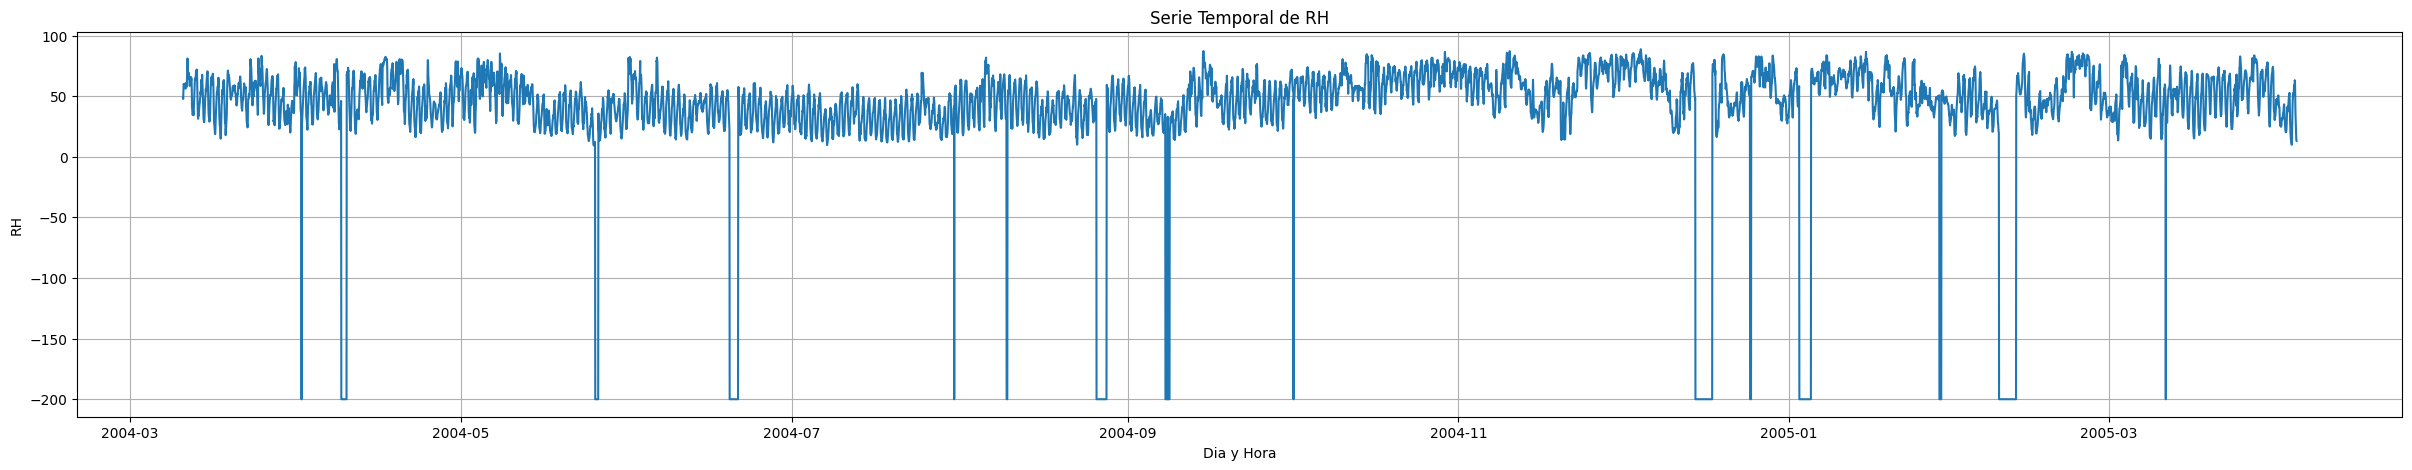

In [ ]:
# Graficar la serie temporal de RH
plt.figure(figsize=(30, 5))
plt.plot(df.index, df['RH'], linestyle='-')
plt.title('Serie Temporal de RH')
plt.xlabel('Dia y Hora')
plt.ylabel('RH')
plt.grid(True)
plt.show()

Se puede apreciar que hay valores -200. Al tratarse de un valor no lógico para las variables en cuestión, se optó por tratar estos valores como NA. Se reemplazarán los valores -200 con el método "forward fill" (técnica de imputación de valores nulos en la que cada valor nulo se reemplaza con el último valor válido anterior). Este método es viable de usar en series temporales porque se espera que los valores sigan siendo válidos hasta que se observe un nuevo valor.

In [ ]:
# Variable RH
# Reemplazar los valores -200 en la columna RH con NaN
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['RH'].fillna(method='ffill', inplace=True)

Se vuelve a graficar la serie para apreciar las modificaciones realizadas

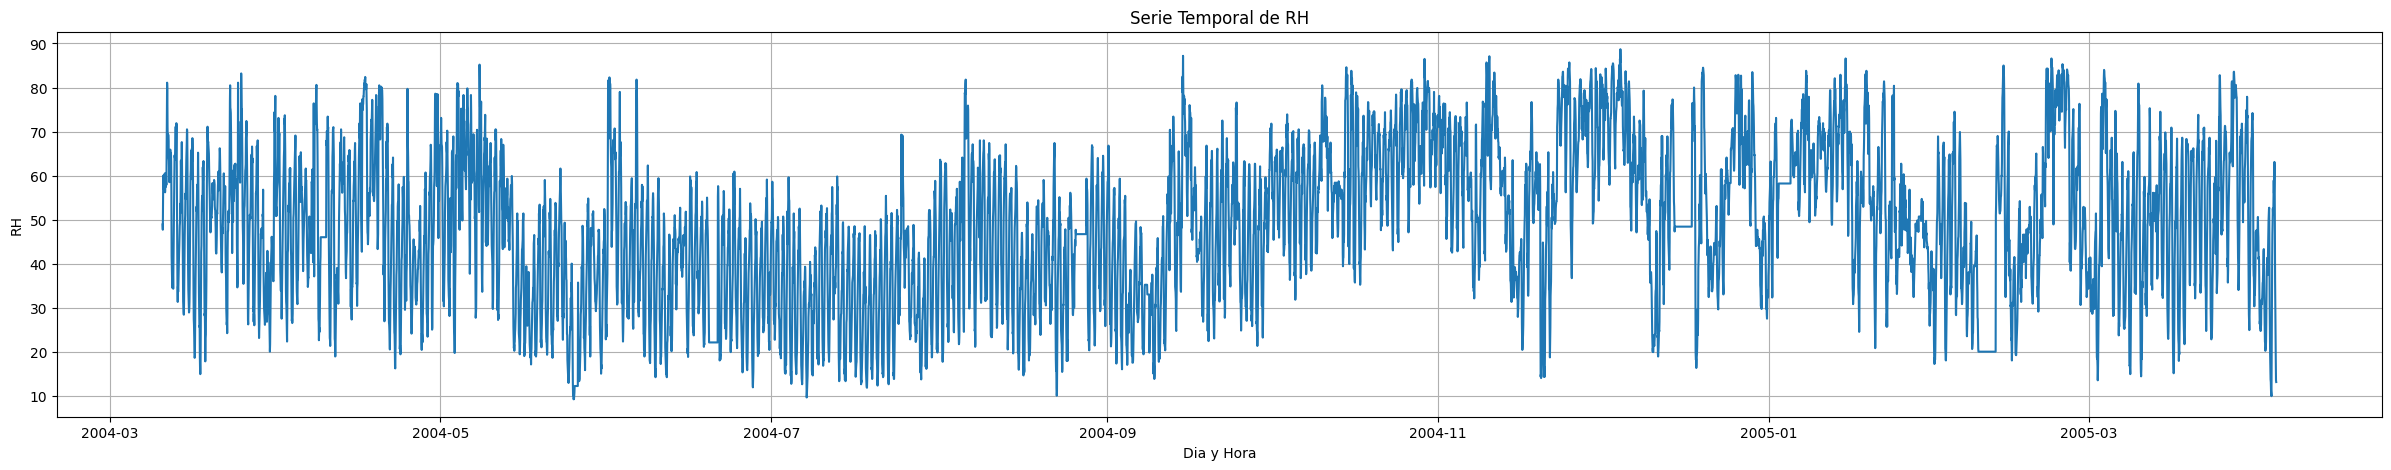

In [ ]:
# Graficar la serie temporal de RH
plt.figure(figsize=(30, 5))
plt.plot(df.index, df['RH'], linestyle='-')
plt.title('Serie Temporal de RH')
plt.xlabel('Dia y Hora')
plt.ylabel('RH')
plt.grid(True)
plt.show()

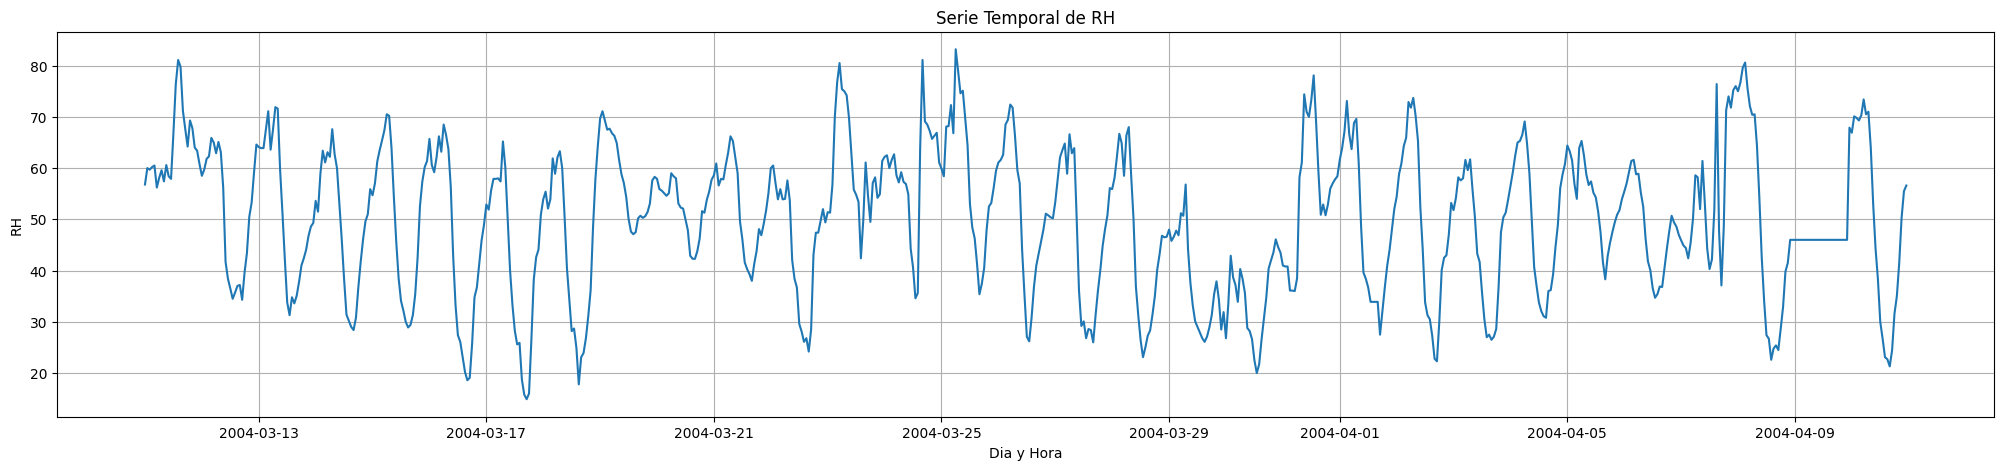

In [ ]:
# Filtrar la serie para un mes para ver con claridad la estacionalidad
start_datetime = '2004-03-11 00:00:00'
end_datetime = '2004-04-10 23:00:00'
df_filtrado_RH = df.loc[start_datetime:end_datetime]

# Graficar la serie temporal de RH para una semana
plt.figure(figsize=(25, 5))
plt.plot(df_filtrado_RH.index, df_filtrado_RH['RH'], linestyle='-')
plt.title('Serie Temporal de RH')
plt.xlabel('Dia y Hora')
plt.ylabel('RH')
plt.grid(True)
plt.show()

**Descomposición de la Serie RH**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

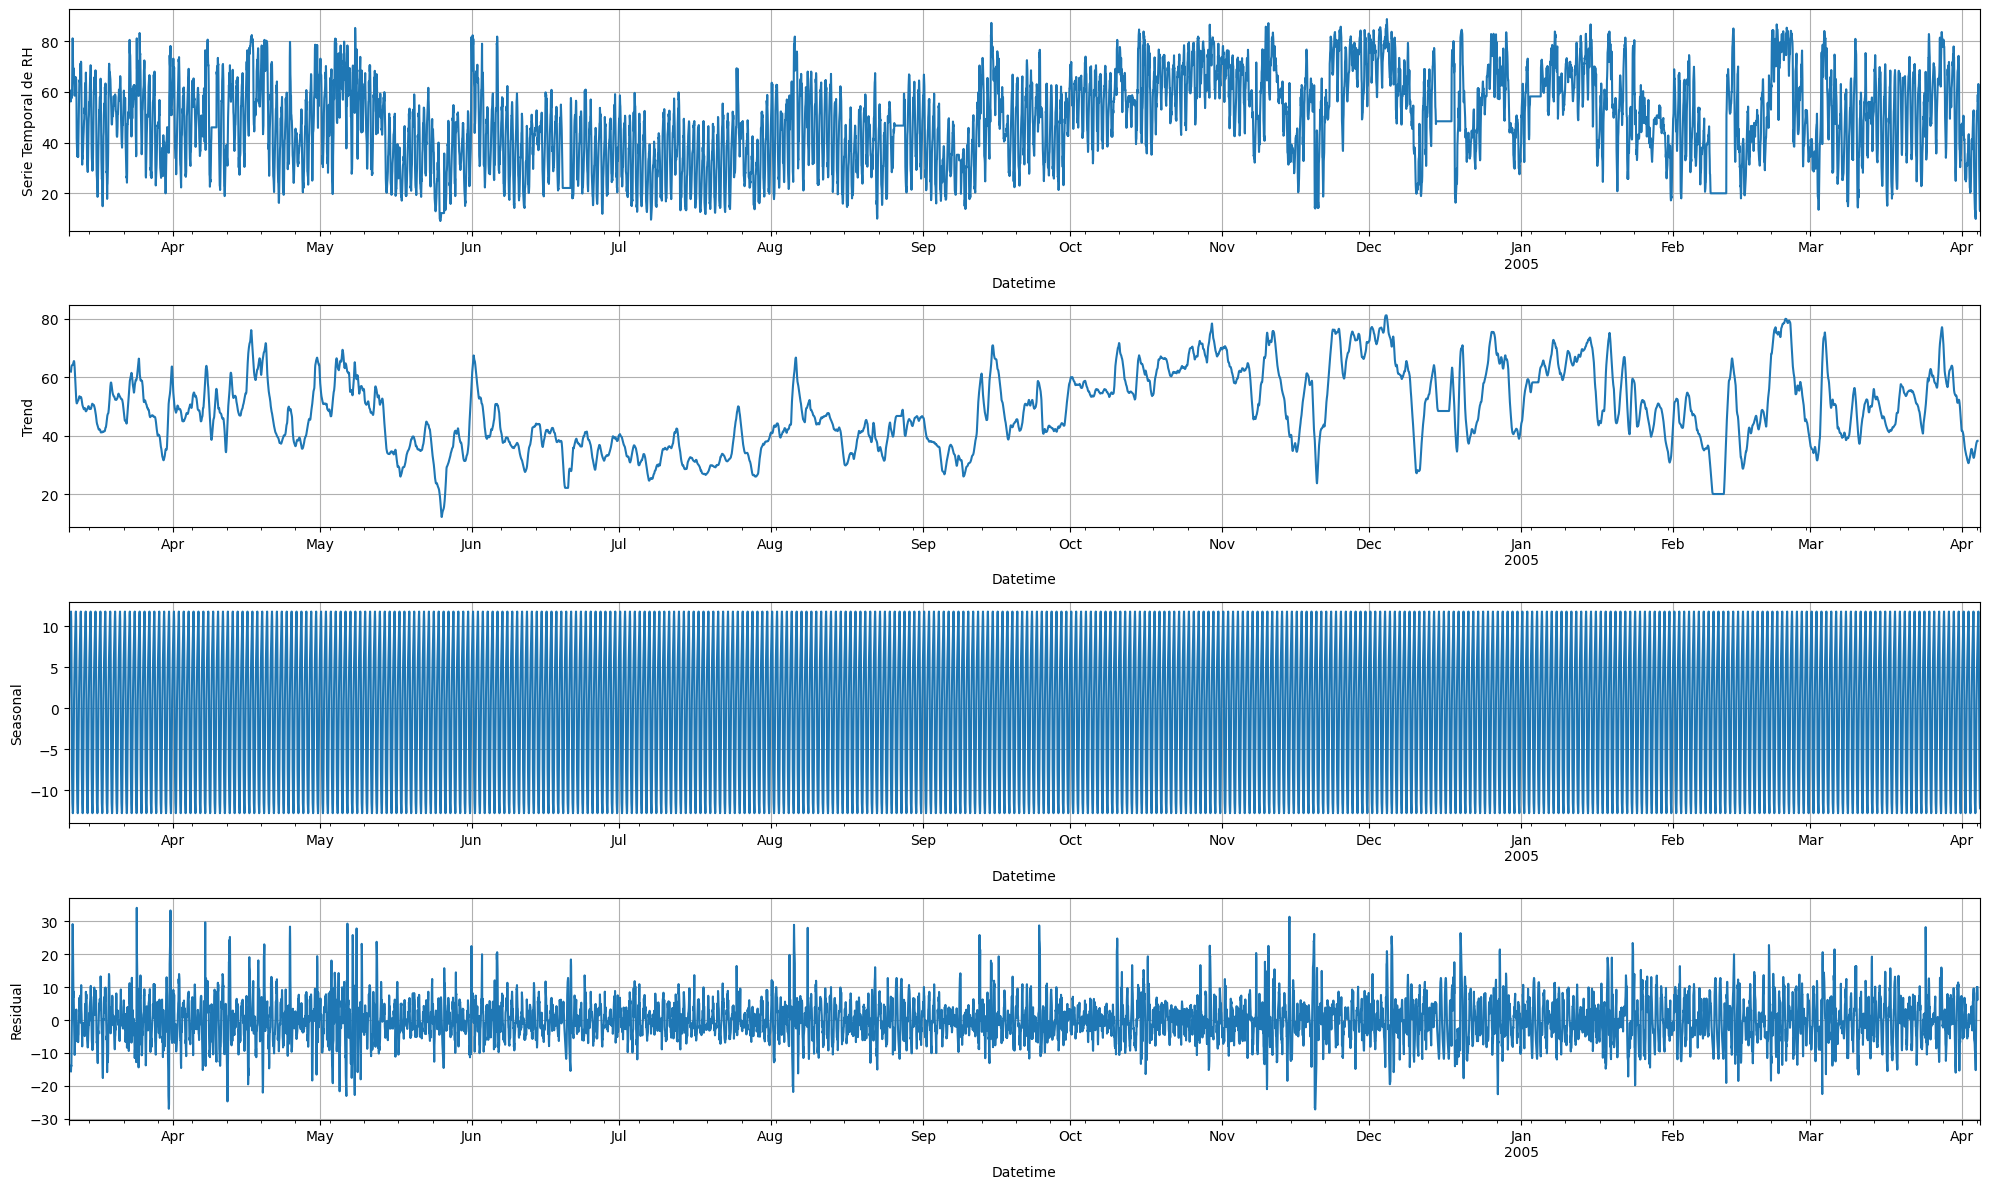

In [ ]:
# Realizar la descomposición estacional aditiva
result_RH = seasonal_decompose(df['RH'], model='additive', period=24)

# Configurar el tamaño de la figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))

# Ploteo de los resultados de la descomposición
plt.subplot(411) # espacio entre los gráficos
result_RH.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Serie Temporal de RH')
ax1.grid(True)

plt.subplot(412)
result_RH.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
ax2.grid(True)

plt.subplot(413)
result_RH.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
ax3.grid(True)

plt.subplot(414)
result_RH.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
ax4.grid(True)

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()


### **PUNTO 3:**
*Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?*

Variable RH

In [ ]:
import statsmodels.api as sm

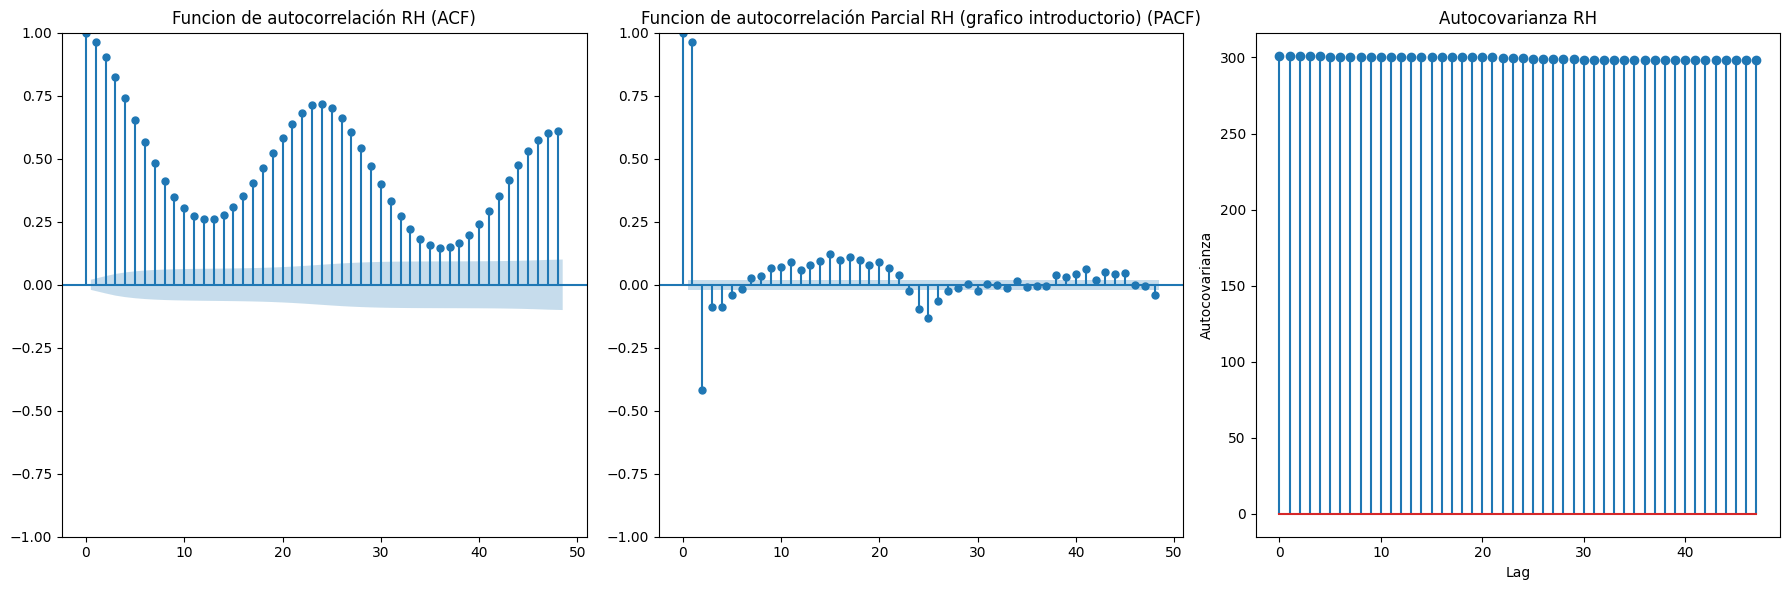

In [ ]:

# Gráficas de ACF, PACF y autocovarianza para RH

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
Y=df['RH']
sm.graphics.tsa.plot_acf(Y, lags=48, ax=ax[0])
ax[0].set_title('Funcion de autocorrelación RH (ACF)')

sm.graphics.tsa.plot_pacf(Y, lags=48, ax=ax[1])
ax[1].set_title('Funcion de autocorrelación Parcial RH (grafico introductorio) (PACF)')

def autocovariance(series, lag):
    series_mean = np.mean(series)
    n = len(series)
    return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

lags = np.arange(48)
autocov = [autocovariance(Y, lag) for lag in lags]

ax[2].stem(lags, autocov, use_line_collection=True)
ax[2].set_title('Autocovarianza RH')
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('Autocovarianza')

plt.tight_layout()
plt.show()

**Analisis de los gráficos**

**Gráfico FAC:** Se observa un patrón importante de estacionalidad que se repite diariamente. Todos los valores están fuera de la banda de confianza, por lo tanto las correlaciones son significativas.

**Gráfico PFAC:** Se observan cortes abruptos los cuales indican estacionalidad.

**Gráficos Autocovarianzas:** Se observan valores muy similares lo que lleva a interpretar que es una serie de memoria larga.



In [ ]:
import pmdarima as pm

**a) Diferenciacion de la parte no estacional**

Al observar el gráfico no hay evidencia de existir tendencia. Para constatalo se determina el numero de diferenciaciones

In [ ]:
# Determinamos  el número óptimo de diferenciaciones no estacionales
n_diffs = pm.arima.ndiffs(df['RH'], test='adf')
print("Número óptimo de diferenciaciones no estacionales:", n_diffs)

Número óptimo de diferenciaciones no estacionales: 0


No requiere diferenciaciones para la parte no estacional.

**b) Diferenciación 24 hs de la parte estacionaria**

In [ ]:
# Diferenciación regular d=24 hora de RH transformado
df_RH_24 = df['RH'].diff(24).dropna()
print(len(df_RH_24))

9333


## **PUNTO 4:**
*Realizar distintas pruebas de raices unitarias para determinar si las series son o no estacionarias*

**a) Test ADF (Dickey-Fuller Aumentado)**

El Test ADF evalúa la hipótesis nula de que una serie temporal tiene una raíz unitaria (es no estacionaria).

Hipótesis nula (H0): La serie tiene una raíz unitaria (la serie no es estacionaria).

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log

In [ ]:
# RealizaR el test de Dickey-Fuller sobre la serie RH

ADF_RH = adfuller(df['RH'])
print('ADF Statistic: %f' % ADF_RH[0]) # imprime sólo el estadístico
print('p-value: %f' % ADF_RH[1]) # imprime sólo el p-valor

ADF Statistic: -7.317636
p-value: 0.000000


El p-valor es 0 < 0,05  por lo tanto se rechaza la H0. Se asume la H1: la serie es estacionaria.
Esto implica que la media y la varianza constantes.
Se puede aplicar el modelo ARIMA


**b) Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

El Test KPSS se utiliza una hipótesis nula contraria al test anterior.

Hipótesis nula (H0): La serie es estacionaria, no presenta raiz unitaria.

In [ ]:
# Realizar el Test KPSS

kpss_RH = kpss(df['RH'])
print('Kpss Statistic: %f' % kpss_RH[0])  # imprime sólo el estadístico
print('p-value: %f' % kpss_RH[1])  # imprime sólo el p-valor



Kpss Statistic: 2.721378
p-value: 0.010000


<ipython-input-30-6f7d38c488f4>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_RH = kpss(df['RH'])


El p-valor es 0.01 < 0.05 se rechaza la H0. Se asume que la serie es no estacionaria.




**c) Test PP (Phillips-Perron)**

Se utiliza para detectar la presencia de raíces unitarias en una serie temporal.

Hipótesis nula (H0): La serie tiene una raíz unitaria (la serie es no estacionaria).

In [ ]:
from arch.unitroot import PhillipsPerron

# Realizar el test de Phillips-Perron
pp_result_RH = PhillipsPerron(df['RH'])

# Mostramos los resultados
print('PP Statistic:', pp_result_RH.stat)
print('p-value:', pp_result_RH.pvalue)


PP Statistic: -12.515124805017035
p-value: 2.6218139760470978e-23


P-valor es 0 < 0.05 por lo que se rechazo la H0. Se asume que la serie es estacionaria.

## **PUNTO 5:**
*Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).*

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'PACF DE RH diferenciada 24 hs')

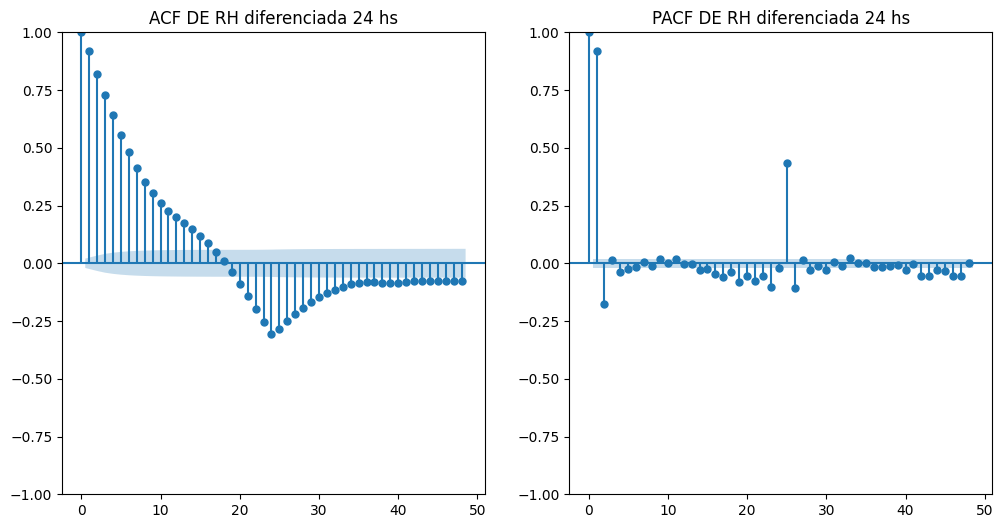

In [ ]:
# Ya tenemos el ACF y PACF de la serie original, ahora lo graficamos para la serie con una diferenciación de 24
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
Y=df_RH_24
sm.graphics.tsa.plot_acf(Y, lags=48, ax=ax[0])
ax[0].set_title('ACF DE RH diferenciada 24 hs')

sm.graphics.tsa.plot_pacf(Y, lags=48, ax=ax[1])
ax[1].set_title('PACF DE RH diferenciada 24 hs')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

**MODELOS SARIMA**

Se fijan los valores de d=0 y D=1 y probamos con valores de p, q, P y Q entre 0 y 2. Se ajustarán (disminuyendo su valor)también estos lags si se observa que algun coeficiente no es significativo.

Se descarta grid search se satura la RAM disponible


In [ ]:
# Primer modelo (1,0,1)(1,1,1,24)
modelo1_RH = SARIMAX(df['RH'], order=(1,0,1), seasonal_order=(1,1,1,24))
modelo1_RH_fit = modelo1_RH.fit()
print(modelo1_RH_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                 RH   No. Observations:                 9357
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -25453.572
Date:                            Mon, 08 Jul 2024   AIC                          50917.145
Time:                                    01:24:29   BIC                          50952.851
Sample:                                03-10-2004   HQIC                         50929.273
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9415      0.003    280.425      0.000       0.935       0.948
ma.L1          0.1928      0.007   

In [ ]:
# Segundo modelo (1,0,1)(2,1,1,24)
modelo2_RH = SARIMAX(df['RH'], order=(1,0,1), seasonal_order=(2,1,1,24))
modelo2_RH_fit = modelo2_RH.fit()
print(modelo2_RH_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                 RH   No. Observations:                 9357
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 24)   Log Likelihood              -25453.128
Date:                            Mon, 08 Jul 2024   AIC                          50918.256
Time:                                    01:30:49   BIC                          50961.104
Sample:                                03-10-2004   HQIC                         50932.810
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9413      0.003    279.629      0.000       0.935       0.948
ma.L1          0.1930      0.007   

In [ ]:
# Tercer modelo (1,0,1)(0,1,2,24)
modelo3_RH = SARIMAX(df['RH'], order=(1,0,1), seasonal_order=(0,1,1,24))
modelo3_RH_fit = modelo3_RH.fit()
print(modelo3_RH_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                 RH   No. Observations:                 9357
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 24)   Log Likelihood              -25460.096
Date:                            Mon, 08 Jul 2024   AIC                          50928.193
Time:                                    01:32:14   BIC                          50956.758
Sample:                                03-10-2004   HQIC                         50937.895
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9429      0.003    284.779      0.000       0.936       0.949
ma.L1          0.1934      0.007   

In [ ]:
# Cuarto modelo (1,0,2)(1,1,1,24)
modelo4_RH = SARIMAX(df['RH'], order=(1,0,2), seasonal_order=(1,1,1,24))
modelo4_RH_fit = modelo4_RH.fit()
print(modelo4_RH_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                   RH   No. Observations:                 9357
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -25453.111
Date:                              Mon, 08 Jul 2024   AIC                          50918.221
Time:                                      01:56:14   BIC                          50961.069
Sample:                                  03-10-2004   HQIC                         50932.775
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9428      0.004    258.738      0.000       0.936       0.950
ma.L1          0.18

In [ ]:
# Quinto modelo (1,0,0)(1,1,1,24)
modelo5_RH = SARIMAX(df['RH'], order=(1,0,0), seasonal_order=(1,1,1,24))
modelo5_RH_fit = modelo5_RH.fit()
print(modelo5_RH_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                   RH   No. Observations:                 9357
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood              -25606.822
Date:                              Mon, 08 Jul 2024   AIC                          51221.645
Time:                                      01:58:09   BIC                          51250.210
Sample:                                  03-10-2004   HQIC                         51231.347
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9569      0.003    367.377      0.000       0.952       0.962
ar.S.L24       0.04

In [ ]:
# Sexto modelo (2,0,1)(1,1,1,24)
modelo6_RH = SARIMAX(df['RH'], order=(2,0,1), seasonal_order=(1,1,1,24))
modelo6_RH_fit = modelo6_RH.fit()
print(modelo6_RH_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                 RH   No. Observations:                 9357
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -25453.103
Date:                            Tue, 09 Jul 2024   AIC                          50918.207
Time:                                    08:20:02   BIC                          50961.054
Sample:                                03-10-2004   HQIC                         50932.760
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8872      0.039     22.705      0.000       0.811       0.964
ar.L2          0.0523      0.038   

In [ ]:
# Séptimo modelo (1,0,1)(1,1,2,24)
modelo7_RH = SARIMAX(df['RH'], order=(1,0,1), seasonal_order=(1,1,2,24))
modelo7_RH_fit = modelo7_RH.fit()
print(modelo7_RH_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                        
Dep. Variable:                                      RH   No. Observations:                 9357
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 24)   Log Likelihood              -25453.208
Date:                                 Tue, 09 Jul 2024   AIC                          50918.417
Time:                                         08:34:06   BIC                          50961.265
Sample:                                     03-10-2004   HQIC                         50932.970
                                          - 04-04-2005                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9413      0.003    279.666      0.000       0.935       0

Al analizar los valores obtenidos, se opta por el modelo 1 [texto del enlace](https://docs.google.com/spreadsheets/d/1EvuHaxhNZTM18ItsS0pYelomecI3wAsA/edit?usp=drive_link&ouid=106776308098076286911&rtpof=true&sd=true)

## **PUNTO 6:**
Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

In [ ]:
# Separación Train/Test la serie RH en 80% y 20%

df_RH_train = df['RH'].iloc[:round(len(df['RH'])*.8)]
df_RH_test = df['RH'].iloc[round(len(df['RH'])*.8):]


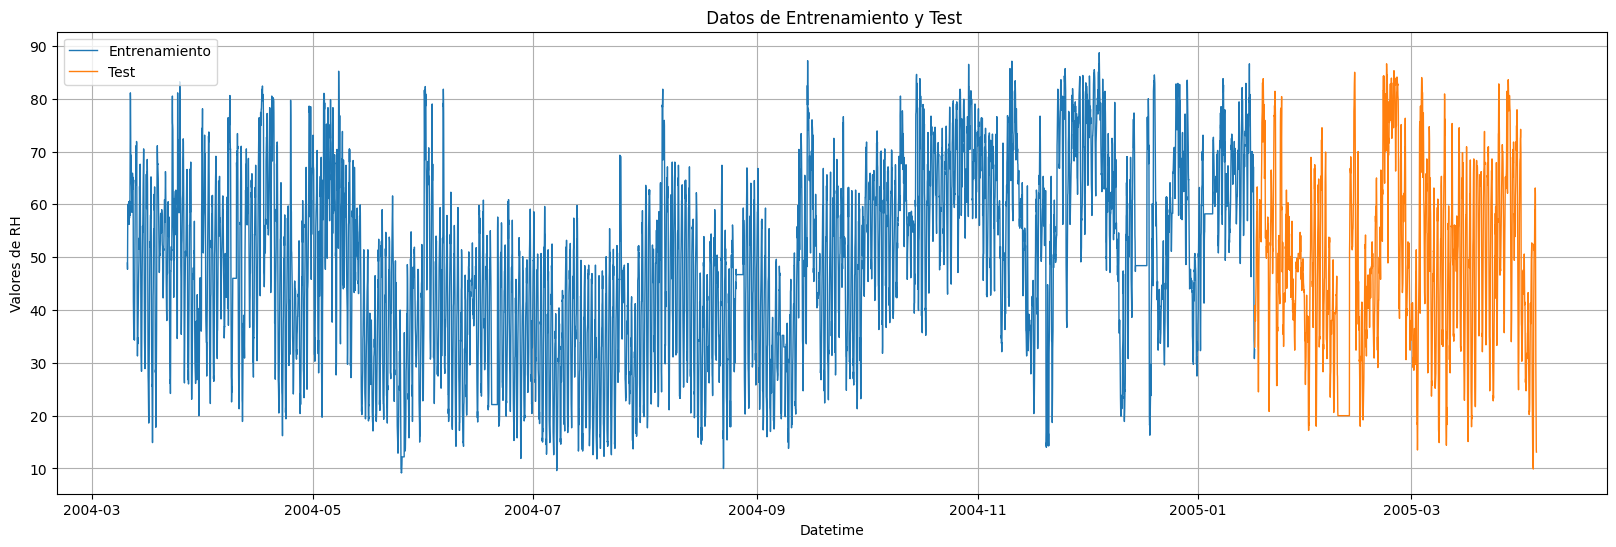

In [ ]:
# Gráficos train y test
plt.figure(figsize=(20, 6))

plt.plot(df_RH_train, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_RH_test, label='Test', linestyle='-', linewidth=1)

plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datetime')
plt.ylabel('Valores de RH')

plt.legend()
plt.grid(True)
plt.show()

Análisis de performance del Modelo 1

In [ ]:
import statsmodels.api as sm

In [ ]:
# Ajustar el modelo 1 con los datos de entrenamiento
modelo1_RH_train = sm.tsa.SARIMAX(df_RH_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
resultados_modelo1 = modelo1_RH_train.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [ ]:
# Realizar predicciones en el conjunto de prueba
predicciones_RH = resultados_modelo1.get_forecast(steps=len(df_RH_test))
predicciones_RH_mean = predicciones_RH.predicted_mean
print (predicciones_RH_mean)

2005-01-16 16:00:00    34.316508
2005-01-16 17:00:00    38.798410
2005-01-16 18:00:00    43.276924
2005-01-16 19:00:00    45.497405
2005-01-16 20:00:00    47.134955
                         ...    
2005-04-04 10:00:00    59.723443
2005-04-04 11:00:00    54.711162
2005-04-04 12:00:00    51.908052
2005-04-04 13:00:00    49.980981
2005-04-04 14:00:00    49.569208
Freq: H, Name: predicted_mean, Length: 1871, dtype: float64


In [ ]:
# Intervalos de confianza
intervalos_confianza = predicciones_RH.conf_int()
print(intervalos_confianza)

                      lower RH   upper RH
2005-01-16 16:00:00  27.154382  41.478634
2005-01-16 17:00:00  28.081467  49.515354
2005-01-16 18:00:00  30.210645  56.343204
2005-01-16 19:00:00  30.670102  60.324708
2005-01-16 20:00:00  30.916665  63.353244
...                        ...        ...
2005-04-04 10:00:00  33.149511  86.297375
2005-04-04 11:00:00  28.136944  81.285380
2005-04-04 12:00:00  25.333582  78.482522
2005-04-04 13:00:00  23.406290  76.555673
2005-04-04 14:00:00  22.994322  76.144095

[1871 rows x 2 columns]


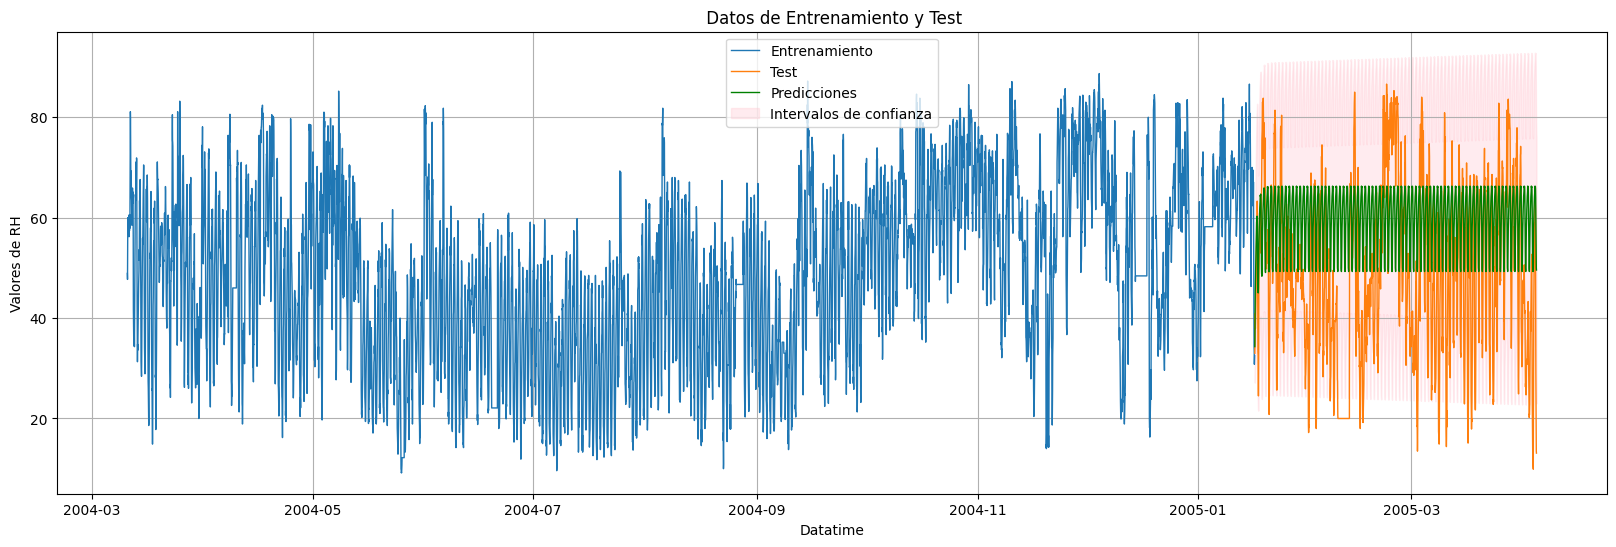

In [ ]:
# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(df_RH_train, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_RH_test, label='Test', linestyle='-', linewidth=1)
plt.plot(df_RH_test.index, predicciones_RH_mean, label='Predicciones', color='green', linestyle='-', linewidth=1 )

# Añadir los intervalo de confianza a la gráfica
plt.fill_between(df_RH_test.index,
                 intervalos_confianza.iloc[:, 0],
                 intervalos_confianza.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalos de confianza')


plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datatime')
plt.ylabel('Valores de RH')
plt.grid(True)
plt.legend()
plt.show()


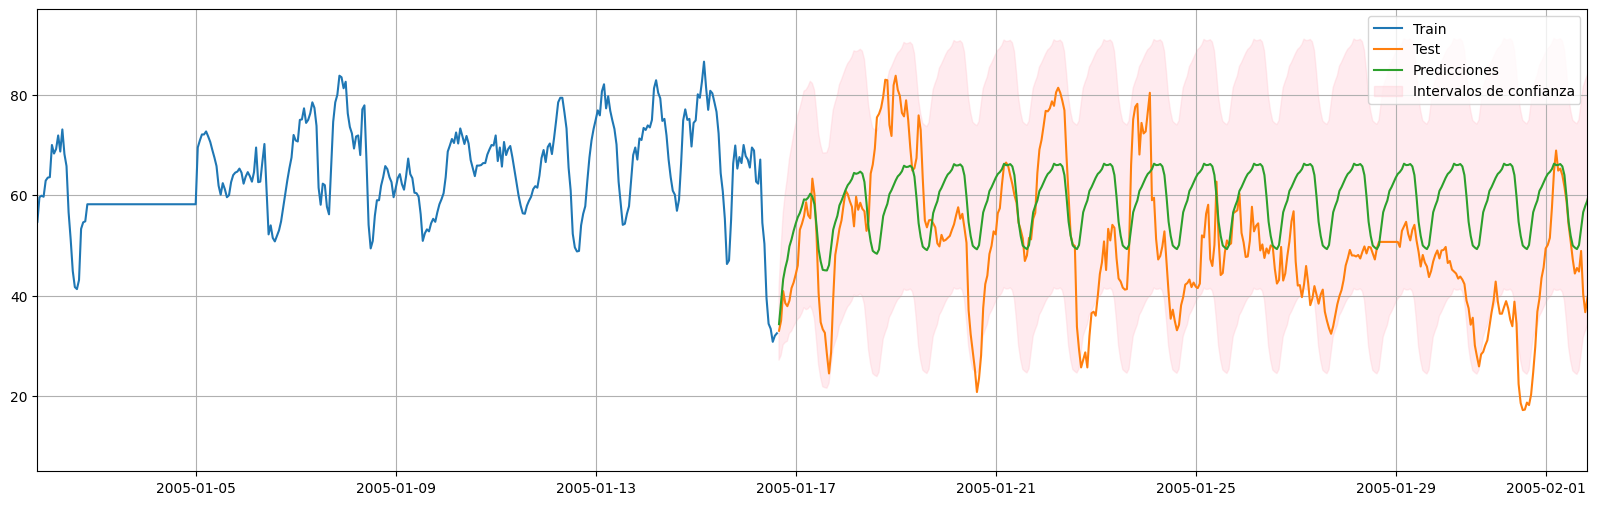

In [ ]:
# Graficar los resultados con mayor detalle acortando los limites de tiempos

start_date = pd.Timestamp('2005-01-01 20:00:00')
end_date = pd.Timestamp('2005-02-01 20:00:00')

plt.figure(figsize=(20, 6))
plt.plot(df_RH_train, label='Train')
plt.plot(df_RH_test.index, df_RH_test, label='Test')
plt.plot(df_RH_test.index, predicciones_RH_mean, label='Predicciones')

plt.fill_between(df_RH_test.index,
                 intervalos_confianza.iloc[:, 0],
                 intervalos_confianza.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalos de confianza')

# Establecemos los límites del eje x
plt.xlim([start_date, end_date])
plt.grid(True)
plt.legend()
plt.show()

**Métricas de Performance**

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# Error cuadrático medio (MSE)
mse_RH = mean_squared_error(df_RH_test, predicciones_RH_mean )
print(f"Error cuadrático medio (MSE) en conjunto de prueba modelo 1 variable RH: {mse_RH}")


Error cuadrático medio (MSE) en conjunto de prueba modelo 1 variable RH: 338.7695768513108


In [ ]:
# Error absoluto medio (MAE)
mae_RH = mean_absolute_error(df_RH_test, predicciones_RH_mean)

print(f"Error Absoluto Medio (MAE) en conjunto de prueba modelo 1 variable RH: {mae_RH}")

Error Absoluto Medio (MAE) en conjunto de prueba modelo 1 variable RH: 15.202706020223355


In [ ]:
# Raiz cuadrada de MSE (RMSE)
rmse_RH = np.sqrt(mse_RH)

print(f"Raíz cuadrada del MSE en conjunto de prueba modelo 1 variable RH: {rmse_RH}")

Raíz cuadrada del MSE en conjunto de prueba modelo 1 variable RH: 18.405694142066764


In [ ]:
# Promedio de los errores porcentuales absolutos
mape_RH = np.mean(np.abs((df_RH_test- predicciones_RH_mean) / df_RH_test)) * 100

print(f"Promedio de los errores porcentuales absolutos de prueba modelo 1 variable RH: {mape_RH}")

Promedio de los errores porcentuales absolutos de prueba modelo 1 variable RH: 45.15204133275937


##**PUNTO 7:**

*Detallar una comparación con otros modelos estimados.*

Se compara con el **Modelo 3** (segundo mejor modelo)

In [ ]:
# Ajustar el modelo 3 con los datos de entrenamiento
modelo3_RH_train = sm.tsa.SARIMAX(df_RH_train, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24))
resultados_modelo3 = modelo3_RH_train.fit()

In [ ]:
# Realizar la predicción en el conjunto de prueba
predicciones_RH_3 = resultados_modelo3.get_forecast(steps=len(df_RH_test))
predicciones_RH_mean3 = predicciones_RH_3.predicted_mean

In [ ]:
# Error cuadrático medio (MSE)
mse_RH_3 = mean_squared_error(df_RH_test, predicciones_RH_mean3)
print(f"Error cuadrático medio (MSE) en conjunto de prueba modelo 3 variable RH: {mse_RH_3}")

Error cuadrático medio (MSE) en conjunto de prueba modelo 3 variable RH: 342.30370389220735


In [ ]:
# Error absoluto medio (MAE)
mae_RH_3 = mean_absolute_error(df_RH_test, predicciones_RH_mean3)
print(f"Error Absoluto Medio (MAE) en conjunto de prueba modelo 3 variable RH: {mae_RH_3}")

Error Absoluto Medio (MAE) en conjunto de prueba modelo 3 variable RH: 15.292132664979697


In [ ]:
# Raiz cuadrada de MSE (RMSE)
rmse_RH_3 = np.sqrt(mse_RH_3)
print(f"Raíz cuadrada del MSE en conjunto de prueba modelo 3 variable RH: {rmse_RH_3}")

Raíz cuadrada del MSE en conjunto de prueba modelo 3 variable RH: 18.50145139961207


In [ ]:
# Promedio de los errores porcentuales absolutos
mape_RH_3 = np.mean(np.abs((df_RH_test- predicciones_RH_mean3) / df_RH_test)) * 100
print(f"Promedio de los errores porcentuales absolutos de prueba modelo 3 variable RH: {mape_RH_3}")

Promedio de los errores porcentuales absolutos de prueba modelo 3 variable RH: 45.44609307864049


Se compara con el **Modelo 5** (peor modelo)

In [ ]:
# Ajustar el modelo 5 con los datos de entrenamiento
modelo5_RH_train = sm.tsa.SARIMAX(df_RH_train, order=(1, 0, 0), seasonal_order=(1, 1, 1, 24))
resultados_modelo5 = modelo5_RH_train.fit()

In [ ]:
# Realizar la predicción en el conjunto de prueba
predicciones_RH_5 = resultados_modelo5.get_forecast(steps=len(df_RH_test))
predicciones_RH_mean5 = predicciones_RH_5.predicted_mean

In [ ]:
# Error cuadrático medio (MSE)
mse_RH_5 = mean_squared_error(df_RH_test, predicciones_RH_mean5)
print(f"Error cuadrático medio (MSE) en conjunto de prueba modelo 5 variable RH: {mse_RH_5}")

Error cuadrático medio (MSE) en conjunto de prueba modelo 5 variable RH: 335.0780459718203


In [ ]:
# Error absoluto medio (MAE)
mae_RH_5 = mean_absolute_error(df_RH_test, predicciones_RH_mean5)
print(f"Error Absoluto Medio (MAE) en conjunto de prueba modelo 5 variable RH: {mae_RH_5}")

Error Absoluto Medio (MAE) en conjunto de prueba modelo 5 variable RH: 15.094809904790802


In [ ]:
# Raiz cuadrada de MSE (RMSE)
rmse_RH_3 = np.sqrt(mse_RH_3)
print(f"Raíz cuadrada del MSE en conjunto de prueba modelo 3 variable RH: {rmse_RH_3}")

Raíz cuadrada del MSE en conjunto de prueba modelo 3 variable RH: 18.50145139961207


In [ ]:
# Promedio de los errores porcentuales absolutos
mape_RH_5 = np.mean(np.abs((df_RH_test- predicciones_RH_mean5) / df_RH_test)) * 100
print(f"Promedio de los errores porcentuales absolutos de prueba modelo 5 variable RH: {mape_RH_5}")

Promedio de los errores porcentuales absolutos de prueba modelo 5 variable RH: 44.80592293221371


[Anexo 2: comparativo métricas de los modelos](https://docs.google.com/spreadsheets/d/1a_1ifOEeA-F5Z702Jwmldl_1iOqBHnzh/edit?usp=sharing&ouid=106776308098076286911&rtpof=true&sd=true)


##**PUNTO 8:**

Análisis de los residuos para el Modelo 1

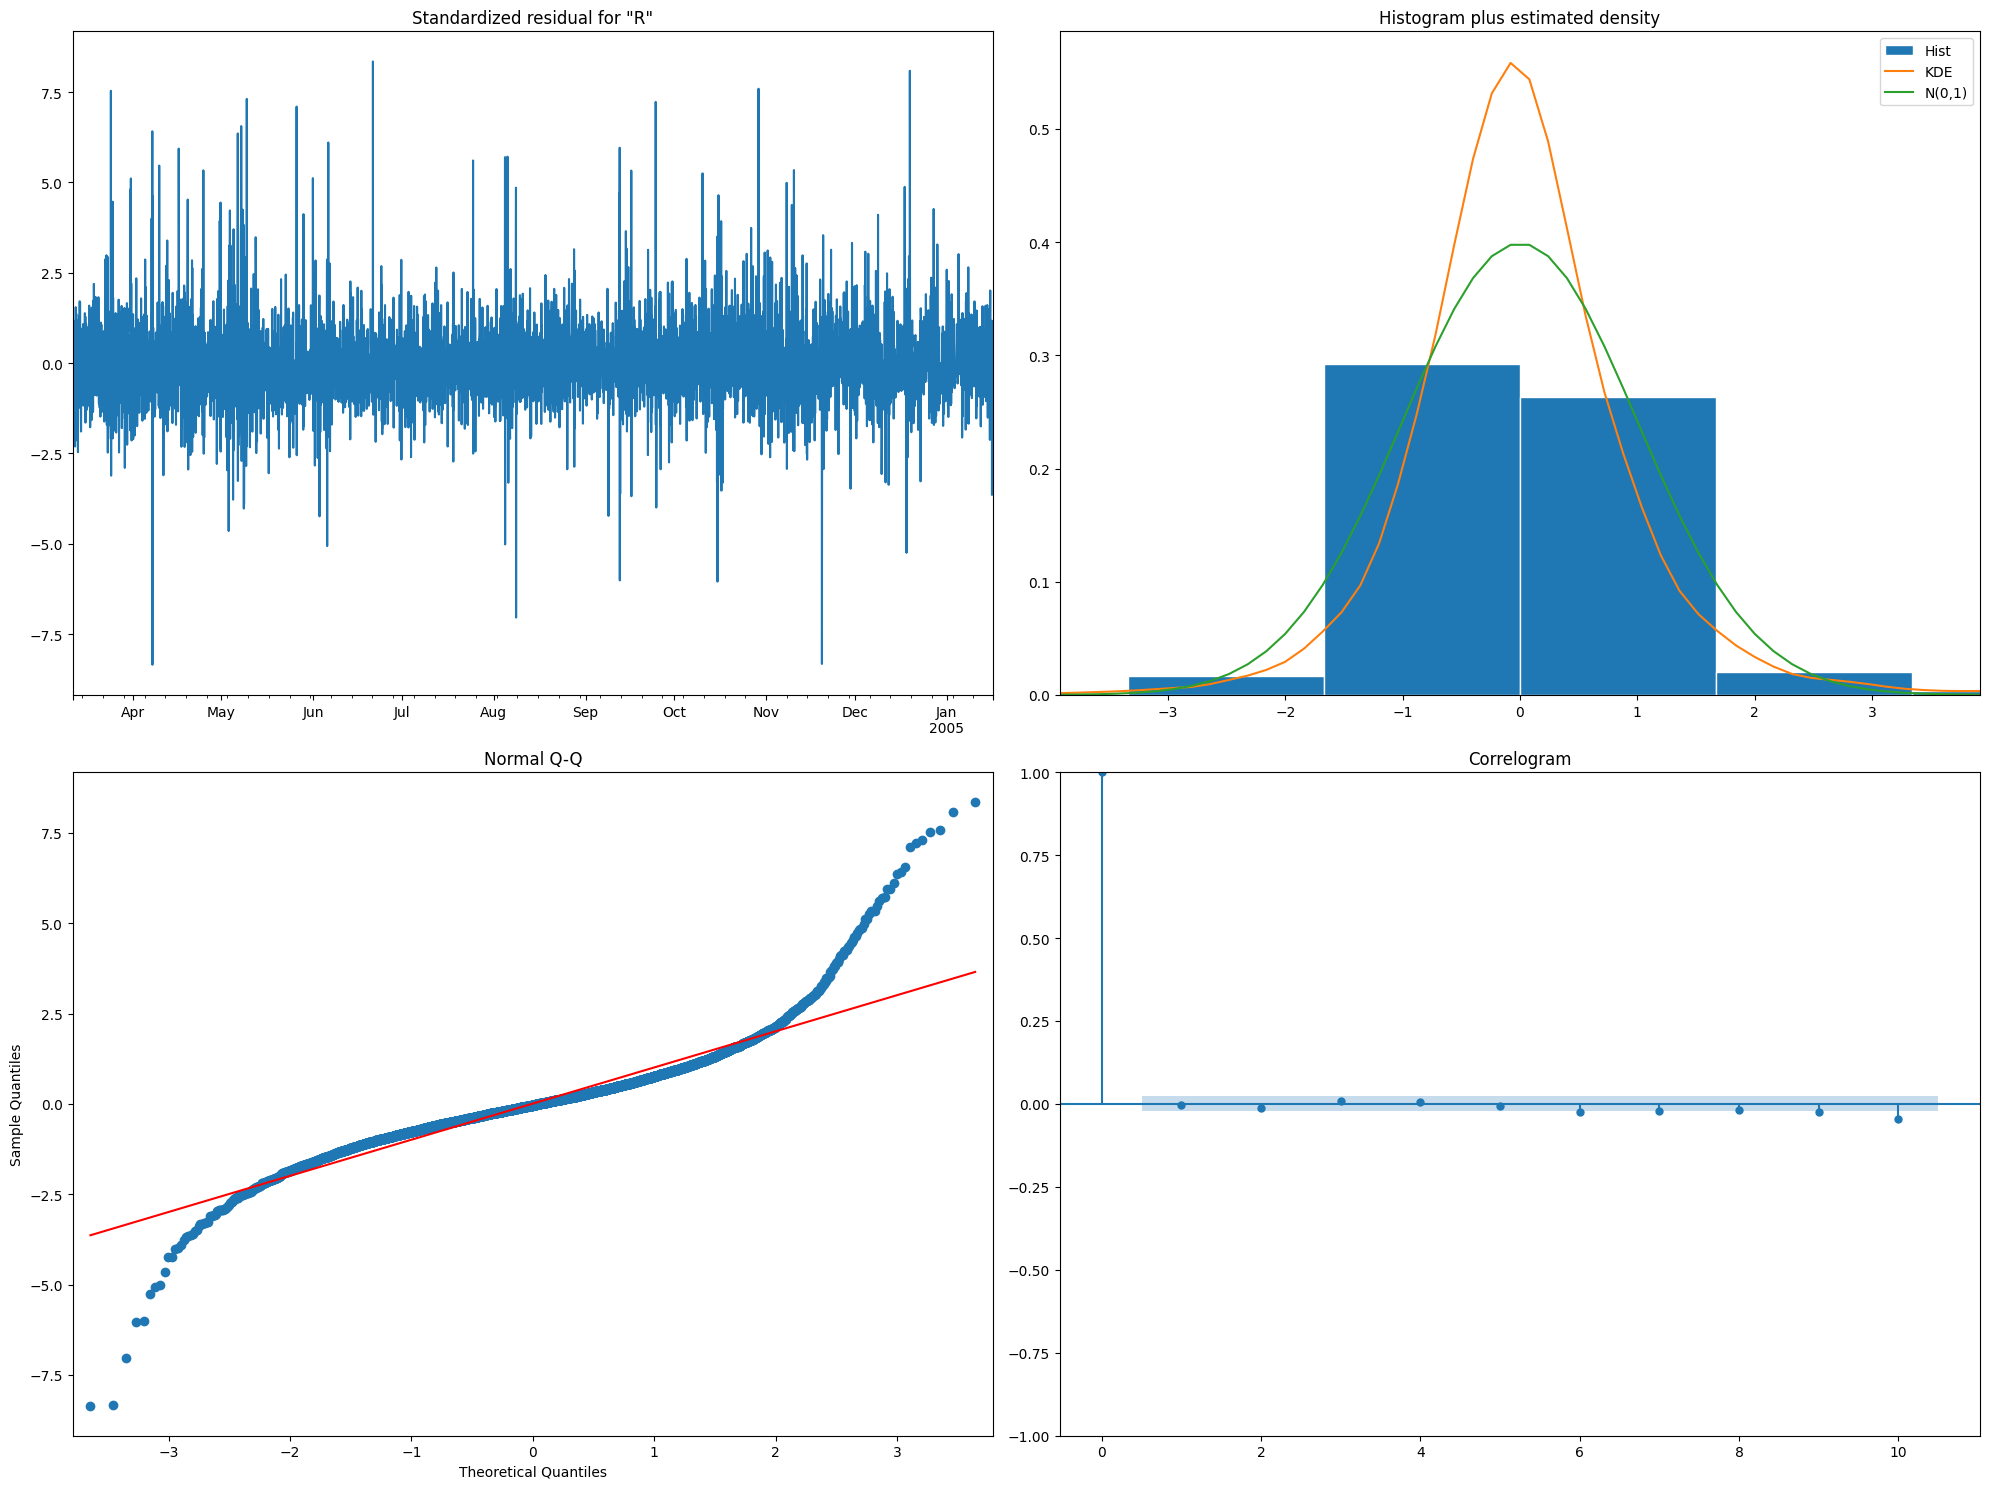

In [ ]:
resultados_modelo1.plot_diagnostics(figsize=(20,15));
plt.tight_layout()
plt.show()

In [ ]:
Incorrelacion_residuos_modelo1=sm.stats.acorr_ljungbox(resultados_modelo1.resid, lags=48)
print(Incorrelacion_residuos_modelo1)

         lb_stat  lb_pvalue
1    1608.912946        0.0
2    3049.639273        0.0
3    4386.080783        0.0
4    5542.577026        0.0
5    6522.865895        0.0
6    7337.645223        0.0
7    8074.519576        0.0
8    8730.754332        0.0
9    9299.875209        0.0
10   9759.894492        0.0
11  10238.332993        0.0
12  10659.253889        0.0
13  11057.084241        0.0
14  11345.460752        0.0
15  11619.446696        0.0
16  11844.630123        0.0
17  12000.016879        0.0
18  12158.849153        0.0
19  12243.405843        0.0
20  12291.028502        0.0
21  12305.596408        0.0
22  12310.827100        0.0
23  12316.376536        0.0
24  12317.141978        0.0
25  12317.450072        0.0
26  12317.657962        0.0
27  12317.663568        0.0
28  12317.984495        0.0
29  12319.131377        0.0
30  12319.332878        0.0
31  12319.510645        0.0
32  12319.676367        0.0
33  12320.227790        0.0
34  12320.245920        0.0
35  12320.347873    

Text(0, 0.5, 'P-valores ')

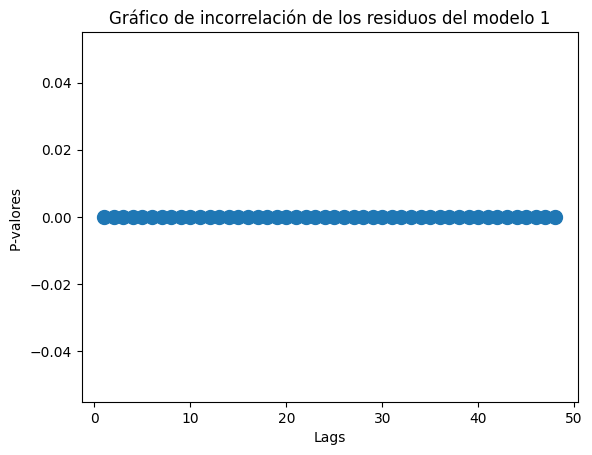

In [ ]:
plt.plot(Incorrelacion_residuos_modelo1.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Gráfico de incorrelación de los residuos del modelo 1")
plt.xlabel("Lags")
plt.ylabel("P-valores ")

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

In [ ]:
# Test Box-Pierce
lags = 10
acf_values = sm.tsa.acf(resultados_modelo1.resid, nlags=lags, fft=False) # Import the statsmodels library and call the acf function using sm.tsa.acf

#Calculamos el estadistico de prueba Q de Box-Pierce
n = len(resultados_modelo1.resid)
Q = n * np.sum(np.square(acf_values[1:lags+1]))
p_value = 1 - chi2.cdf(Q, df=lags)

print(f'Estadística de prueba (Q): {Q:.4f}')
print(f'p_value: {p_value:.4f}')
alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula: Hay autocorrelación significativa en los residuos.")
else:
    print("No se rechaza la hipótesis nula: No hay autocorrelación significativa en los residuos.")

Estadística de prueba (Q): 9751.5390
p_value: 0.0000
Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.


##**PUNTO 9:**

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

In [ ]:
# Tomamos una ventana de 24 horas
Pronostico_RH = resultados_modelo1.get_forecast(steps=24)
Intervalo_confianza_pronostico = Pronostico_RH.conf_int()
Pronostico_RH_mean = Pronostico_RH.predicted_mean

In [ ]:
# Crear el rango de fechas para las predicciones
# Suponer datos horarios y df_RH_test.index[-1] es el último índice del conjunto de prueba
ultimo_dato = df_RH_test.index[-1]
datos_prediccion = pd.date_range(start=ultimo_dato, periods=24, freq='H')
print(datos_prediccion)

DatetimeIndex(['2005-04-04 14:00:00', '2005-04-04 15:00:00',
               '2005-04-04 16:00:00', '2005-04-04 17:00:00',
               '2005-04-04 18:00:00', '2005-04-04 19:00:00',
               '2005-04-04 20:00:00', '2005-04-04 21:00:00',
               '2005-04-04 22:00:00', '2005-04-04 23:00:00',
               '2005-04-05 00:00:00', '2005-04-05 01:00:00',
               '2005-04-05 02:00:00', '2005-04-05 03:00:00',
               '2005-04-05 04:00:00', '2005-04-05 05:00:00',
               '2005-04-05 06:00:00', '2005-04-05 07:00:00',
               '2005-04-05 08:00:00', '2005-04-05 09:00:00',
               '2005-04-05 10:00:00', '2005-04-05 11:00:00',
               '2005-04-05 12:00:00', '2005-04-05 13:00:00'],
              dtype='datetime64[ns]', freq='H')


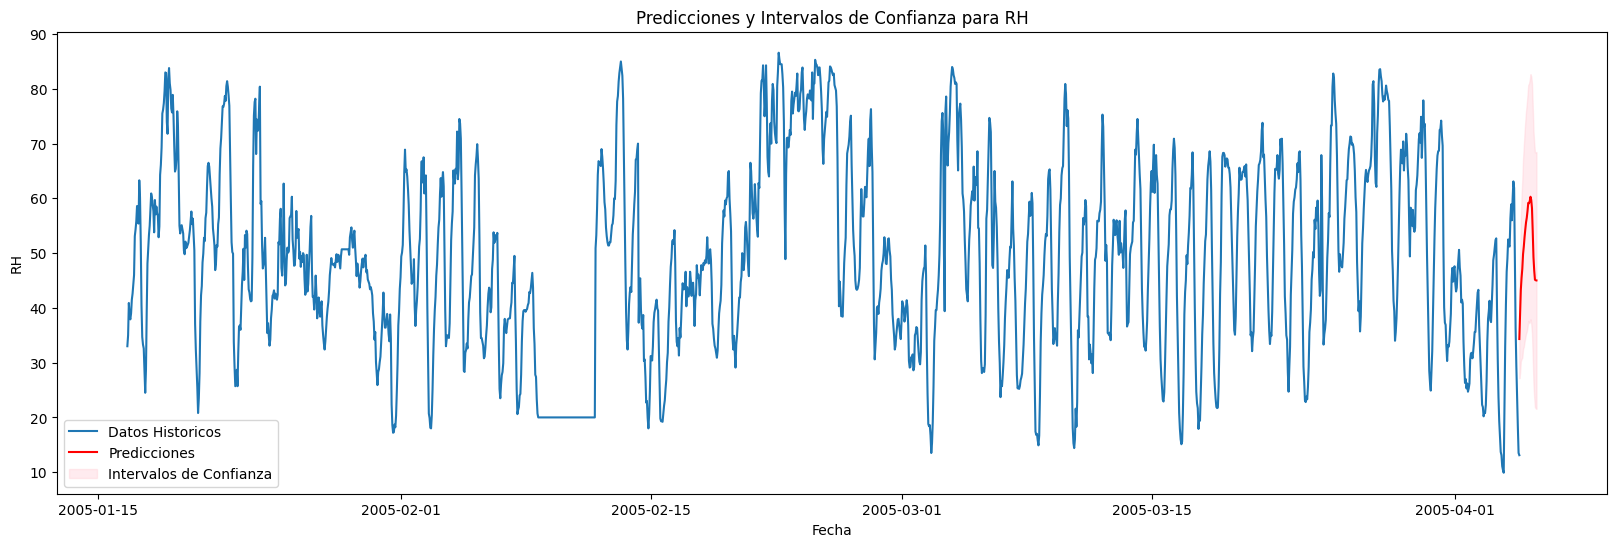

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df_RH_test.index, df_RH_test, label='Datos Historicos')
plt.plot(datos_prediccion, Pronostico_RH_mean, label='Predicciones', color='red')
plt.fill_between(datos_prediccion,
                 Intervalo_confianza_pronostico.iloc[:, 0],
                 Intervalo_confianza_pronostico.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalos de Confianza')

# Configuración adicional de la gráfica
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('RH')
plt.title('Predicciones y Intervalos de Confianza para RH')
plt.show()

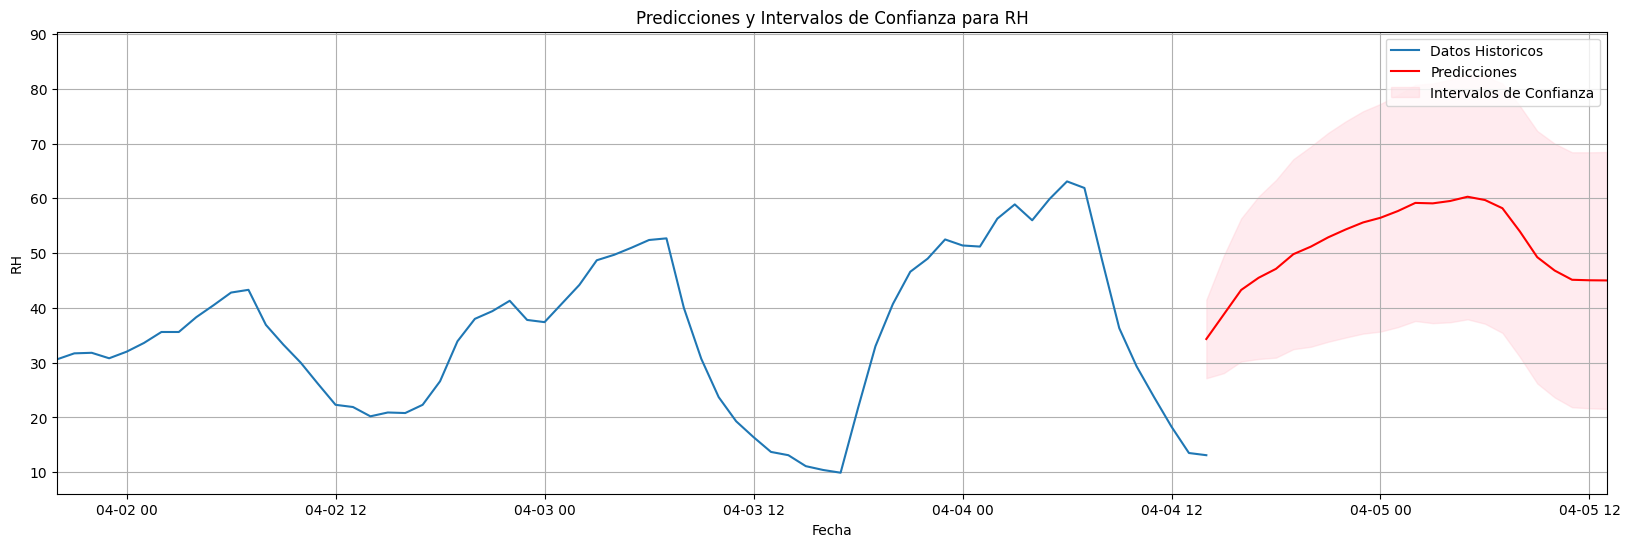

In [ ]:
# Graficar para menos días

plt.figure(figsize=(20, 6))
start_date = pd.Timestamp('2005-04-01 20:00:00')
end_date = pd.Timestamp('2005-04-05 13:00:00')
plt.plot(df_RH_test.index, df_RH_test, label='Datos Historicos')
plt.plot(datos_prediccion, Pronostico_RH_mean, label='Predicciones', color='red')
plt.fill_between(datos_prediccion,
                 Intervalo_confianza_pronostico.iloc[:, 0],
                 Intervalo_confianza_pronostico.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalos de Confianza')

plt.xlim(start_date, end_date)
plt.grid(True)
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('RH')
plt.title('Predicciones y Intervalos de Confianza para RH')
plt.show()